In [51]:
%matplotlib inline

import pandas as pd
import numpy as np

import os

from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(1243)

In [2]:
DATA_DIR = '../data/raw/'

In [3]:
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test-comb.csv'))
sample_sub = pd.read_csv(os.path.join(DATA_DIR, 'Sample_Submission_Tm9Lura.csv'))

In [4]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [5]:
test.head()

,Unnamed: 0,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Comb
0,0,1000004,P00128942,M,46-50,7,B,2,0,1,11.0,NaN,1000004P00128942
1,1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN,1000009P00113442
2,2,1000010,P00288442,F,36-45,1,B,4+,0,5,14.0,NaN,1000010P00288442
3,3,1000010,P00145342,F,36-45,1,B,4+,0,4,9.0,NaN,1000010P00145342
4,4,1000011,P00053842,F,26-35,1,C,1,0,4,5.0,12.0,1000011P00053842


### Frequency count of users

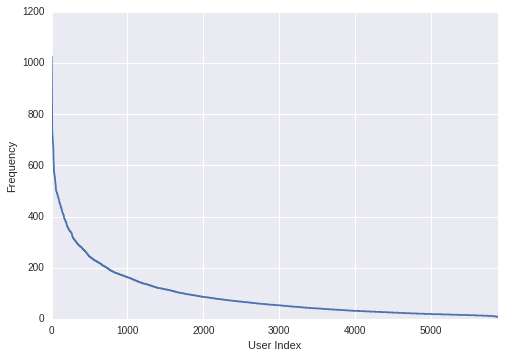

In [13]:
train.User_ID.value_counts().reset_index()['User_ID'].plot()
plt.xlabel('User Index')
plt.ylabel('Frequency');

### Frequency count of products

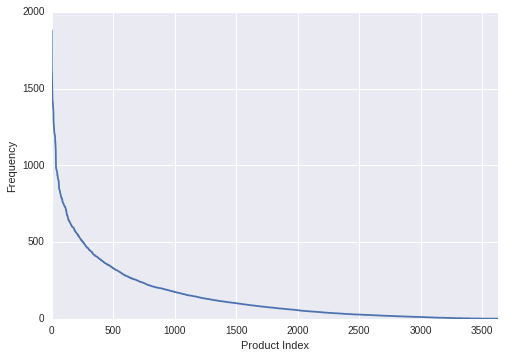

In [12]:
train.Product_ID.value_counts().reset_index()['Product_ID'].plot()
plt.xlabel('Product Index')
plt.ylabel('Frequency');

### Frequency of Purchase Amount

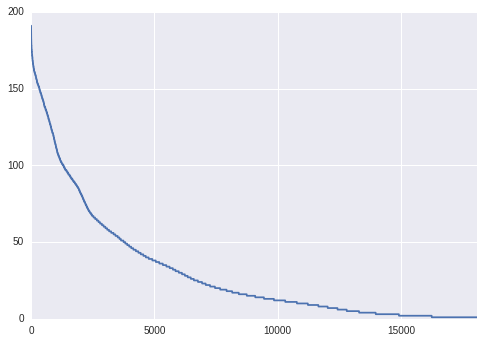

In [17]:
train.Purchase.value_counts().reset_index()['Purchase'].plot();

In [28]:
common_users = np.intersect1d(train.User_ID, test.User_ID)
print('Count of users both in train and test set', len(common_users))
print('User Ids both in train and test set ', common_users)

Count of users both in train and test set 5891
User Ids both in train and test set  [1000001 1000002 1000003 ..., 1006038 1006039 1006040]


In [29]:
common_products = np.intersect1d(train.Product_ID, test.Product_ID)
print('Count of products both in train and test set', len(common_products))
print('Product Ids both in train and test set ', common_products)

Count of products both in train and test set 3445
Product Ids both in train and test set  ['P00000142' 'P00000242' 'P00000342' ..., 'P0099742' 'P0099842' 'P0099942']


In [36]:
# check to see if user id and product id pair is present in test set as well

def f(arrA, arrB):
    return not set(map(tuple, arrA)).isdisjoint(set(map(tuple, arrB)))

f(train[['User_ID', 'Product_ID']].values, test[['User_ID', 'Product_ID']].values)

False

### Split into training and test set

In [39]:
X_train, X_test, y_train, y_test = train_test_split(train, train.Purchase, test_size=0.2, random_state=44)

** Dummy Regressor ( Useful as benchmark ) **

In [52]:
# most frequent value is 7011
pred_rmse = np.sqrt(mean_squared_error(y_test, np.array([7011] * len(y_test))))
print('RMSE on unseen examples for strategy=%s is %f'%('constant', pred_rmse))

RMSE on unseen examples for strategy=constant is 5502.848374


In [55]:
# mean purchase amount in the training set is 9263.968712959126
pred_rmse = np.sqrt(mean_squared_error(y_test, np.array([9263.968712959126] * len(y_test))))
print('RMSE on unseen examples for strategy=%s is %f'%('mean', pred_rmse))

RMSE on unseen examples for strategy=mean is 5024.114972


In [57]:
# median purchase amount in the training set is 8047.0
pred_rmse = np.sqrt(mean_squared_error(y_test, np.array([8047.0] * len(y_test))))
print('RMSE on unseen examples for strategy=%s is %f'%('median', pred_rmse))

RMSE on unseen examples for strategy=median is 5167.509877


** Now we can compare our predictions against these basic benchmarks. **

### Relationship between Gender and Purchase

In [63]:
train.Gender.value_counts()

M    414259
F    135809
Name: Gender, dtype: int64

** There are more men in the training set **

In [64]:
test.Gender.value_counts()

M    175772
F     57827
Name: Gender, dtype: int64

** Similarly there are more men in the test set **

In [79]:
mean_purchase_by_gender = X_train.groupby('Gender')['Purchase'].mean()

In [80]:
mean_purchase_by_gender

Gender
F    8739.175540
M    9439.072323
Name: Purchase, dtype: float64

### Include Gender

In [81]:
def get_mean_purchase_by_gender(gender):
    return mean_purchase_by_gender.ix[gender]

pred_purchase_amount = X_test.Gender.map(get_mean_purchase_by_gender)

In [82]:
pred_rmse = np.sqrt(mean_squared_error(y_test, pred_purchase_amount))
print('RMSE on unseen examples for gender based purchase amount calculation is: %f'%(pred_rmse))

RMSE on unseen examples for gender based purchase amount calculation is: 5014.690067


** We were able to lower our RMSE by including gender. **

### Include Age

In [77]:
train.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

In [88]:
train.Age.value_counts()

26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: Age, dtype: int64

In [83]:
mean_purchase_by_age = X_train.groupby('Age')['Purchase'].mean()

In [86]:
def get_purchase_by_age(age):
    return mean_purchase_by_age.ix[age]

pred_purchase_amount = X_test.Age.map(get_purchase_by_age)

In [87]:
pred_rmse = np.sqrt(mean_squared_error(y_test, pred_purchase_amount))
print('RMSE on unseen examples for gender based purchase amount calculation is: %f'%(pred_rmse))

RMSE on unseen examples for gender based purchase amount calculation is: 5023.600671


### Include both Gender and Age

In [93]:
mean_purchase_by_gender_age = X_train.groupby(['Gender', 'Age'])['Purchase'].mean()

In [94]:
def get_purchase_by_gender_age(row):
    gender = row['Gender']
    age = row['Age']
    return mean_purchase_by_gender_age.ix[(gender, age)]

pred_purchase_amount = X_test.apply(get_purchase_by_gender_age, axis=1)

In [95]:
pred_rmse = np.sqrt(mean_squared_error(y_test, pred_purchase_amount))
print('RMSE on unseen examples for gender based purchase amount calculation is: %f'%(pred_rmse))

RMSE on unseen examples for gender based purchase amount calculation is: 5013.768359


** We can improve on our existing score by including both gender and age. **